# Загрузка данных

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import datetime
import seaborn as sns
import numpy as np
from ydata_profiling import ProfileReport
from scipy.stats import norm

In [53]:
graphics_color = '#23a55c'

In [54]:
users = pd.read_csv('user_data.csv')
orders = pd.read_csv('order_data.csv')
interactions = pd.read_csv('interaction_data.csv')

orders['userid'] = orders['userId']
orders = orders.drop('userId', axis=1)

interactions['userid'] = interactions['UserId']
interactions = interactions.drop('UserId', axis=1)

In [55]:
df = users.merge(orders.groupby(['userid', 'category']).mean().unstack()['avg_bill'], on='userid')

In [56]:
df = df.merge(interactions, on='userid')

In [57]:
df.columns

Index(['userid', 'join_datetime', 'age', 'income', 'kids', 'teenagers',
       'marital', 'education', 'alcohol', 'fish', 'fruits', 'meat', 'other',
       'sweets', 'vegetables', 'complain_count', 'last_order_dt',
       'discount_purchases_count_avg', 'catalogue_purchases_count_avg',
       'store_purchases_count_avg', 'website_purchases_count_avg',
       'website_visit_count_avg', 'mobile_purchases_count_avg',
       'mobile_visit_count_avg', 'marketing_company_outcome_1',
       'marketing_company_outcome_2', 'marketing_company_outcome_3',
       'marketing_company_outcome_4', 'marketing_company_outcome_5'],
      dtype='object')

In [58]:
categories = ['alcohol', 'fish', 'fruits', 'meat', 'other',
       'sweets', 'vegetables']

In [59]:
marital_status = df['marital'].unique()

In [60]:
interact_cols = ['discount_purchases_count_avg', 'catalogue_purchases_count_avg',
       'store_purchases_count_avg', 'website_purchases_count_avg',
       'website_visit_count_avg', 'mobile_purchases_count_avg',
       'mobile_visit_count_avg']

In [61]:
purchases_cols = ['discount_purchases_count_avg', 'catalogue_purchases_count_avg',
       'store_purchases_count_avg', 'website_purchases_count_avg', 'mobile_purchases_count_avg']

In [62]:
marketing_cols = ['marketing_company_outcome_1',
       'marketing_company_outcome_2', 'marketing_company_outcome_3',
       'marketing_company_outcome_4', 'marketing_company_outcome_5']

# Чистка

---

In [63]:
original_size = len(df)

устранение пропущенных значений

In [64]:
print(f'Пропущено ячеек {df[categories].isna().sum().sum()} ({df[categories].isna().sum().sum() / df[categories].count().sum() * 100:.2f}%)')
df[categories] = df[categories].fillna(0)

Пропущено ячеек 1021 (4.48%)


Чистка отрицательного среднего чека по категории

In [65]:
print(f'Ячеек с отрицательным значением {(df[categories] < 0).sum().sum()} ({(df[categories] < 0).sum().sum() / df[categories].count().sum() * 100:.2f}%)')
for cat in categories:
    df[cat] = df[cat].apply(lambda x: max(0, x))

Ячеек с отрицательным значением 1123 (4.71%)


Чистка дохода

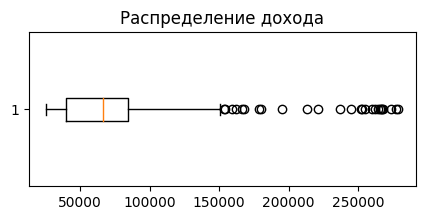

In [66]:
plt.figure(figsize=(5,2))
plt.boxplot(df.income, vert=False);
plt.title('Распределение дохода');

In [67]:
stats = cbook.boxplot_stats(df.income)
lower_treshold = stats[0]['whislo']
upper_treshold = stats[0]['whishi']
deleted = df.shape[0] - df[df.income.between(lower_treshold, upper_treshold)].shape[0]
print(f'Удалено {deleted} пользователей ({deleted / original_size * 100:.2f}%)')
df = df[df.income.between(lower_treshold, upper_treshold)]

Удалено 26 пользователей (0.76%)


Чистка отрицательного числа средних покупок

In [68]:
print(f'Пользователей с отрицательным средним количеством покупок {(df[interact_cols] < 0).any(axis=1).sum(axis=0)} ({(df[interact_cols] < 0).any(axis=1).sum(axis=0) / original_size * 100:.2f}%)')

Пользователей с отрицательным средним количеством покупок 280 (8.22%)


----

# Предобработка

In [69]:
df['total_purchases'] = df[purchases_cols].sum(axis=1)

In [70]:
df['avg_bill'] = df[categories].sum(axis=1)

In [71]:
df['avg_monthly_paid'] = df['total_purchases'] * df['avg_bill']

In [72]:
df['avg_marketing_success'] = df[marketing_cols].mean(axis=1)

In [73]:
df['discount_frac'] = df['discount_purchases_count_avg'] / df['total_purchases']
df.discount_frac = df.discount_frac.fillna(0)

In [74]:
df['total_kids'] = df['kids'] + df['teenagers']

In [75]:
df['favourite_category'] = df[categories].apply(lambda x : categories[x.values.argmax()], axis=1)

In [76]:
df['favourite_order_method'] = df[purchases_cols].apply(lambda x : purchases_cols[x.values.argmax()].split('_')[0], axis=1)

In [77]:
def get_age_group(age):
    if 0 <= age <= 17:
        return '0-17'
    elif 18 <= age <= 35:
        return '18-35'
    elif 36 <= age <= 65:
        return '36-65'
    else:
        return '66+'

df['age_group'] = df.age.apply(get_age_group)
age_groups = sorted(df['age_group'].unique())

# Наблюдения

In [78]:
print(f'Людей, жаловавшихся хотя бы раз {len(df[df.complain_count > 0])} ({len(df[df.complain_count > 0]) / len(df) * 100:.2f}%)')

Людей, жаловавшихся хотя бы раз 1391 (41.17%)


In [79]:
print(f'Среднемесячное количество заказов из онлайн-каталога:    ', df.catalogue_purchases_count_avg.sum())
print(f'Среднемесячное количество заказов в очных магазинах:     ', df.store_purchases_count_avg.sum())
print(f'Среднемесячное количество заказов на сайте:              ', df.website_purchases_count_avg.sum())
print(f'Среднемесячное количество заказов в мобильном приложении:', df.mobile_purchases_count_avg.sum())

Среднемесячное количество заказов из онлайн-каталога:     6954
Среднемесячное количество заказов в очных магазинах:      15326
Среднемесячное количество заказов на сайте:               11084
Среднемесячное количество заказов в мобильном приложении: 36543


In [80]:
df = df[df.website_visit_count_avg > 0]
print('Средняя вероятность покупки при заходе на сайт:', (df.website_purchases_count_avg / df.website_visit_count_avg).mean())
df = df[df.mobile_visit_count_avg > 0]
print('Средняя вероятность покупки при заходе в мобильное приложение:', (df.mobile_purchases_count_avg / df.mobile_visit_count_avg).mean())
print('(Сильно доверяться этому не стоит, т.к. среднее количество посещений/покупок в месяц\nхранится в целых числах и вероятно было округлено)')

Средняя вероятность покупки при заходе на сайт: 0.8181412292560427
Средняя вероятность покупки при заходе в мобильное приложение: 0.47952910365900714
(Сильно доверяться этому не стоит, т.к. среднее количество посещений/покупок в месяц
хранится в целых числах и вероятно было округлено)


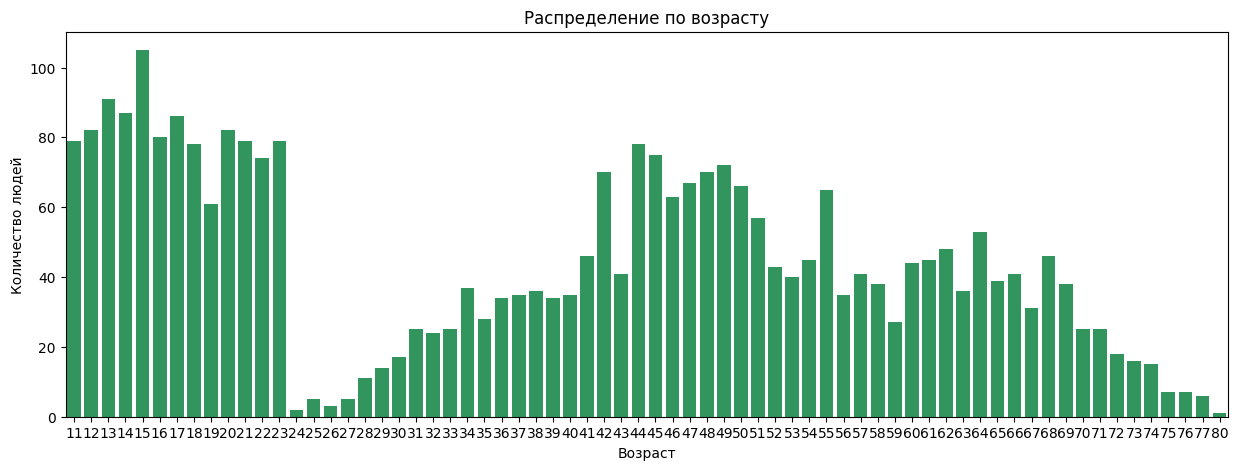

In [81]:
plt.figure(figsize=(15, 5))
sns.barplot(x='age', y='count', data = pd.DataFrame({'age' : df.age, 'count' : df.age.map(df.age.value_counts().sort_index())}), color=graphics_color)
plt.xlabel('Возраст')
plt.ylabel('Количество людей')
plt.title('Распределение по возрасту')
plt.show()

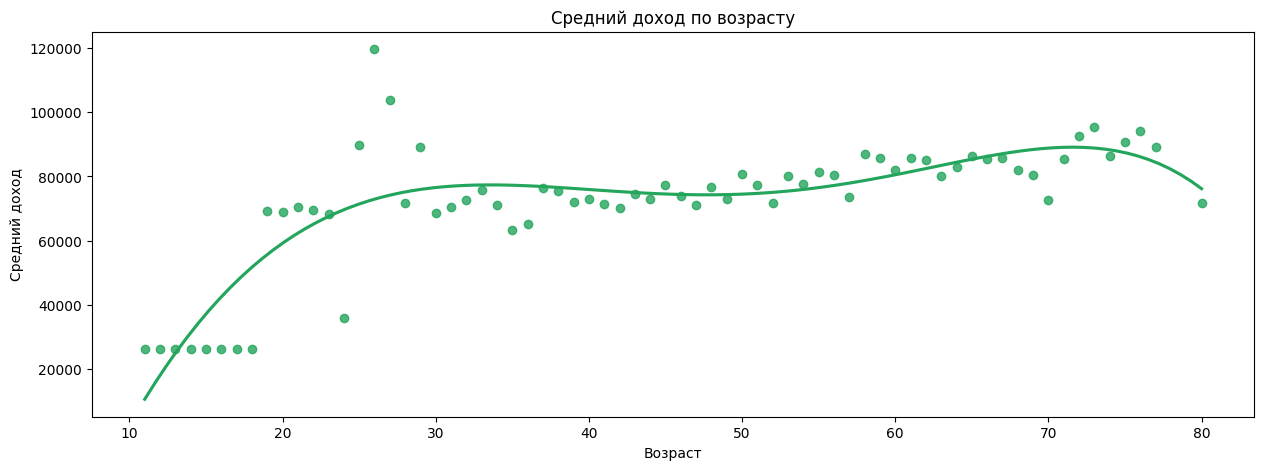

In [82]:
plt.figure(figsize=(15,5))
sns.regplot(x='age', y='income', data=df.groupby('age').income.mean().reset_index(), ci=None, order=5, color=graphics_color)
plt.xlabel('Возраст')
plt.ylabel('Средний доход')
plt.title('Средний доход по возрасту')
plt.show()

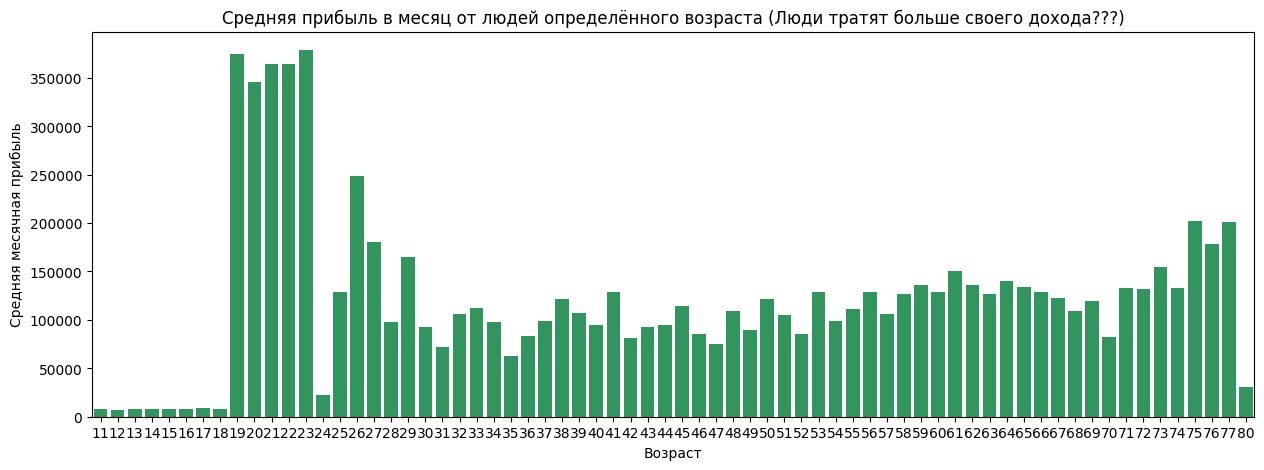

In [83]:
plt.figure(figsize=(15, 5))
sns.barplot(x='age', y='avg_monthly_paid', data = df.groupby('age').avg_monthly_paid.mean().reset_index(), color=graphics_color)
plt.xlabel('Возраст')
plt.ylabel('Средняя месячная прибыль')
plt.title('Средняя прибыль в месяц от людей определённого возраста (Люди тратят больше своего дохода???)')
plt.show()

# Скорее всего средний чек по категории учитывает только покупки, в которых были товары этой категории
# И предположительный общий средний чек мы считаем неправильно

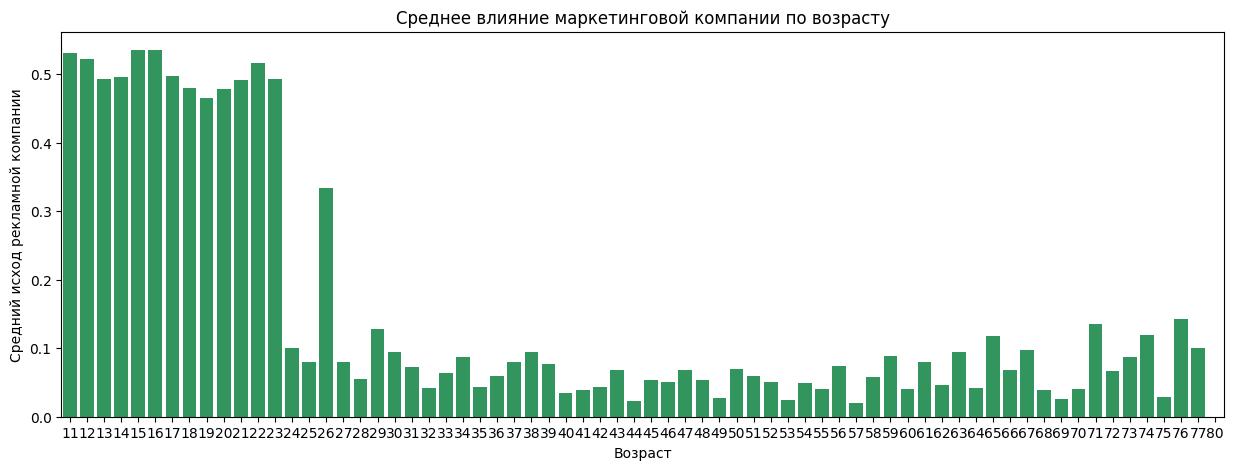

In [84]:
plt.figure(figsize=(15, 5))
sns.barplot(x='age', y='avg_marketing_success', data = df.groupby('age')[f'avg_marketing_success'].mean().reset_index(), color=graphics_color)
plt.xlabel('Возраст')
plt.ylabel('Средний исход рекламной компании')
plt.title('Среднее влияние маркетинговой компании по возрасту')
plt.show()

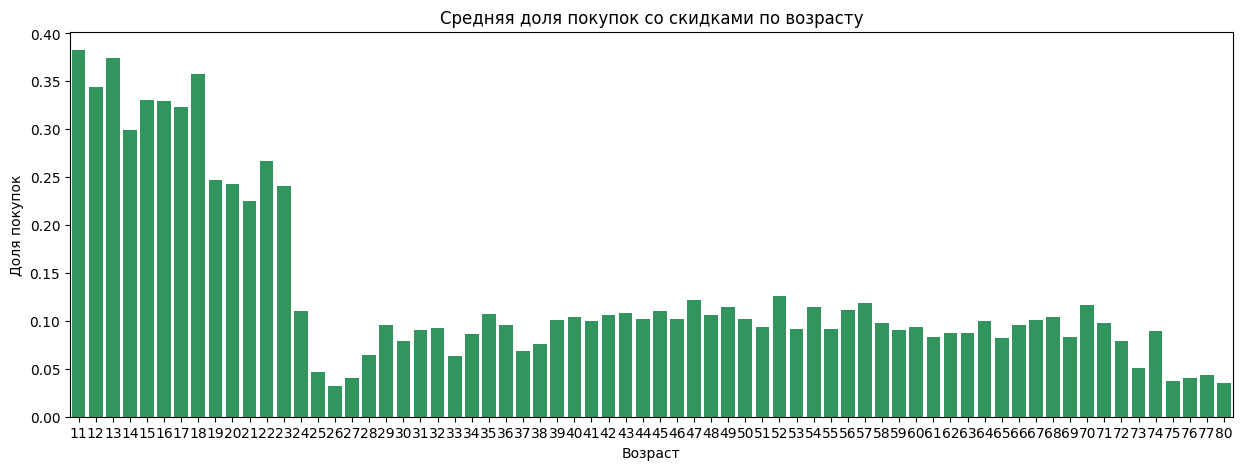

In [85]:
plt.figure(figsize=(15, 5))
sns.barplot(x='age', y='discount_frac', data = df.groupby('age').discount_frac.mean().reset_index(), color=graphics_color)
plt.xlabel('Возраст')
plt.ylabel('Доля покупок')
plt.title('Средняя доля покупок со скидками по возрасту')
plt.show()

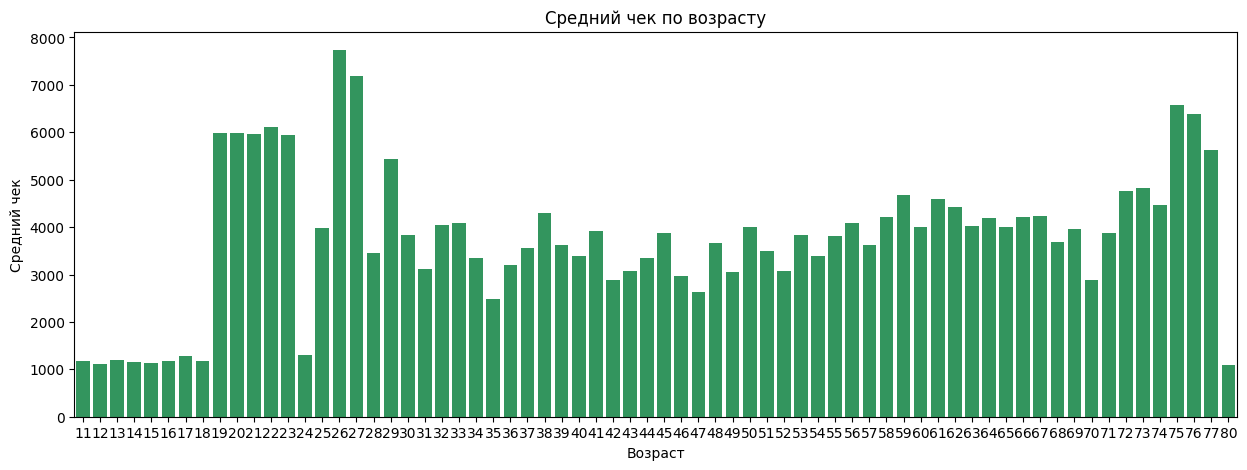

In [86]:
plt.figure(figsize=(15, 5))
sns.barplot(x='age', y='avg_bill', data = df.groupby('age').avg_bill.mean().reset_index(), color=graphics_color)
plt.xlabel('Возраст')
plt.ylabel('Средний чек')
plt.title('Средний чек по возрасту')
plt.show()

In [87]:
import scipy
def t_test(feature, desc):
    for i in range(3):
        sample_A = df[df.age_group == age_groups[i]][feature]
        sample_B = df[df.age_group == age_groups[i + 1]][feature]
        
        result = 'equal'
            
        for alt in ['less', 'greater']:
            # Perform independent sample t-test
            t_statistic, p_value = scipy.stats.ttest_ind(sample_A, sample_B, alternative=alt)
            
            # Set the significance level (alpha)
            alpha = 0.01
            
            # Compute the degrees of freedom (df) (n_A-1)+(n_b-1)
            df1 = len(sample_A)+len(sample_B)-2
            
            # Calculate the critical t-value
            # ppf is used to find the critical t-value for a two-tailed test
            critical_t = scipy.stats.t.ppf(1 - alpha/2, df1)
            
            print('\n---> Тест', age_groups[i], '<' if alt == 'less' else '>', age_groups[i + 1], '???')
            
            print("T-value:", t_statistic)
            print("P-Value:", p_value)
            print("Critical t-value:", critical_t)
            
            #Критерий для отвержения нулевой гипотезы
            if np.abs(t_statistic) > critical_t and p_value <= alpha:
                print(f'Правдива альтернативная гипотеза\n{desc} по группе', age_groups[i], '<' if alt == 'less' else '>', age_groups[i + 1])
                result = alt
            else:
                print('Правдива нулевая гипотеза')
        
        print('-----ИТОГ-----')
        if result == 'equal':
            print(f'{desc} по группе', age_groups[i], '=', age_groups[i+1])
        else:
            print(f'{desc} по группе', age_groups[i], '<' if result == 'less' else '>', age_groups[i + 1])
            
        print('-' * 100)

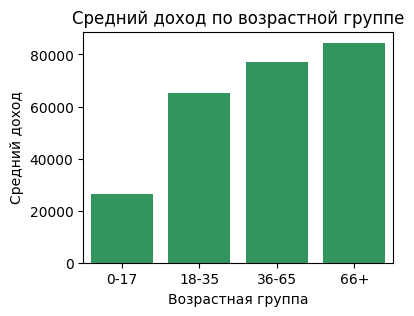

In [88]:
plt.figure(figsize=(4, 3))
sns.barplot(x='age_group', y='income', data = df.groupby('age_group').income.mean().reset_index(), color=graphics_color)
plt.xlabel('Возрастная группа')
plt.ylabel('Средний доход')
plt.title('Средний доход по возрастной группе')
plt.show()

In [89]:
t_test('income', 'Средний доход')


---> Тест 0-17 < 18-35 ???
T-value: -41.68771060196016
P-Value: 1.578294448195336e-239
Critical t-value: 2.579746235721573
Правдива альтернативная гипотеза
Средний доход по группе 0-17 < 18-35

---> Тест 0-17 > 18-35 ???
T-value: -41.68771060196016
P-Value: 1.0
Critical t-value: 2.579746235721573
Правдива нулевая гипотеза
-----ИТОГ-----
Средний доход по группе 0-17 < 18-35
----------------------------------------------------------------------------------------------------

---> Тест 18-35 < 36-65 ???
T-value: -10.975456426898441
P-Value: 1.33570084160948e-27
Critical t-value: 2.578144930760365
Правдива альтернативная гипотеза
Средний доход по группе 18-35 < 36-65

---> Тест 18-35 > 36-65 ???
T-value: -10.975456426898441
P-Value: 1.0
Critical t-value: 2.578144930760365
Правдива нулевая гипотеза
-----ИТОГ-----
Средний доход по группе 18-35 < 36-65
----------------------------------------------------------------------------------------------------

---> Тест 36-65 < 66+ ???
T-value: -5.0

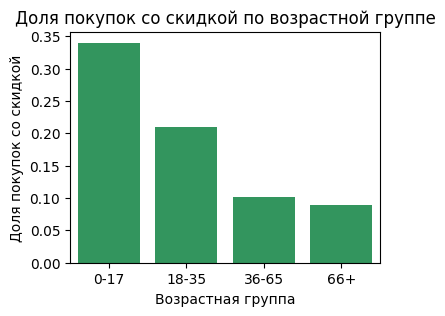

In [90]:
plt.figure(figsize=(4, 3))
sns.barplot(x='age_group', y='discount_frac', data = df.groupby('age_group').discount_frac.mean().reset_index(), color=graphics_color)
plt.xlabel('Возрастная группа')
plt.ylabel('Доля покупок со скидкой')
plt.title('Доля покупок со скидкой по возрастной группе')
plt.show()

In [91]:
t_test('discount_frac', 'Средняя доля покупок по скидкам')


---> Тест 0-17 < 18-35 ???
T-value: 11.54996659805704
P-Value: 1.0
Critical t-value: 2.579746235721573
Правдива нулевая гипотеза

---> Тест 0-17 > 18-35 ???
T-value: 11.54996659805704
P-Value: 1.0604685714901584e-29
Critical t-value: 2.579746235721573
Правдива альтернативная гипотеза
Средняя доля покупок по скидкам по группе 0-17 > 18-35
-----ИТОГ-----
Средняя доля покупок по скидкам по группе 0-17 > 18-35
----------------------------------------------------------------------------------------------------

---> Тест 18-35 < 36-65 ???
T-value: 21.774365754527544
P-Value: 1.0
Critical t-value: 2.578144930760365
Правдива нулевая гипотеза

---> Тест 18-35 > 36-65 ???
T-value: 21.774365754527544
P-Value: 2.3501452224905052e-95
Critical t-value: 2.578144930760365
Правдива альтернативная гипотеза
Средняя доля покупок по скидкам по группе 18-35 > 36-65
-----ИТОГ-----
Средняя доля покупок по скидкам по группе 18-35 > 36-65
-----------------------------------------------------------------------

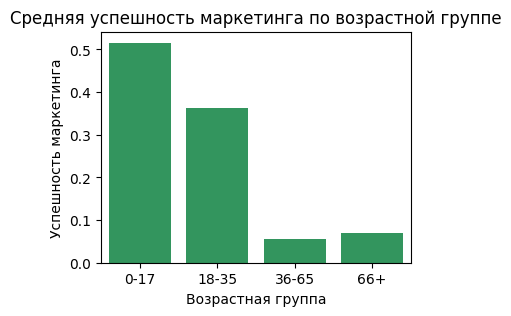

In [92]:
plt.figure(figsize=(4, 3))
sns.barplot(x='age_group', y='avg_marketing_success', data = df.groupby('age_group').avg_marketing_success.mean().reset_index(), color=graphics_color)
plt.xlabel('Возрастная группа')
plt.ylabel('Успешность маркетинга')
plt.title('Средняя успешность маркетинга по возрастной группе')
plt.show()

In [93]:
t_test('avg_marketing_success', 'Средняя успешность маркетинговых компаний')


---> Тест 0-17 < 18-35 ???
T-value: 10.474982575392044
P-Value: 1.0
Critical t-value: 2.579746235721573
Правдива нулевая гипотеза

---> Тест 0-17 > 18-35 ???
T-value: 10.474982575392044
P-Value: 5.643546326403603e-25
Critical t-value: 2.579746235721573
Правдива альтернативная гипотеза
Средняя успешность маркетинговых компаний по группе 0-17 > 18-35
-----ИТОГ-----
Средняя успешность маркетинговых компаний по группе 0-17 > 18-35
----------------------------------------------------------------------------------------------------

---> Тест 18-35 < 36-65 ???
T-value: 34.56235514747262
P-Value: 1.0
Critical t-value: 2.578144930760365
Правдива нулевая гипотеза

---> Тест 18-35 > 36-65 ???
T-value: 34.56235514747262
P-Value: 2.1382939457318497e-208
Critical t-value: 2.578144930760365
Правдива альтернативная гипотеза
Средняя успешность маркетинговых компаний по группе 18-35 > 36-65
-----ИТОГ-----
Средняя успешность маркетинговых компаний по группе 18-35 > 36-65
-------------------------------

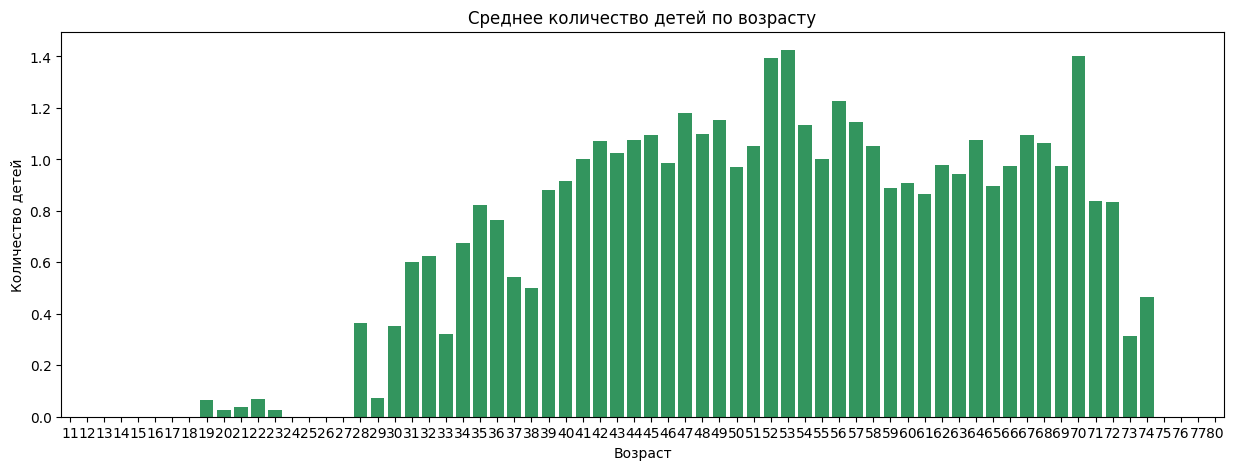

In [94]:
plt.figure(figsize=(15, 5))
sns.barplot(x='age', y='total_kids', data = df.groupby('age').total_kids.mean().reset_index(), color=graphics_color)
plt.xlabel('Возраст')
plt.ylabel('Количество детей')
plt.title('Среднее количество детей по возрасту')
plt.show()

In [95]:
print('Люди до 18 лет включительно:')
print('Средний доход:', df[df.age <= 18].income.mean())
print('Среднее количество покупок по скидке:', df[df.age <= 18].discount_frac.mean())
print('Средняя успешность маркетинговых компаний:', df[df.age <= 18].avg_marketing_success.mean())
print()
print('Люди старше 18 лет:')
print('Средний доход:', df[df.age > 18].income.mean())
print('Среднее количество покупок по скидке:', df[df.age > 18].discount_frac.mean())
print('Средняя успешность маркетинговых компаний:', df[df.age > 18].avg_marketing_success.mean())

Люди до 18 лет включительно:
Средний доход: 26261.26453488372
Среднее количество покупок по скидке: 0.3420788836486511
Средняя успешность маркетинговых компаний: 0.5116279069767442

Люди старше 18 лет:
Средний доход: 76396.59010752688
Среднее количество покупок по скидке: 0.12131151537475592
Средняя успешность маркетинговых компаний: 0.12834408602150538


<Axes: ylabel='favourite_order_method'>

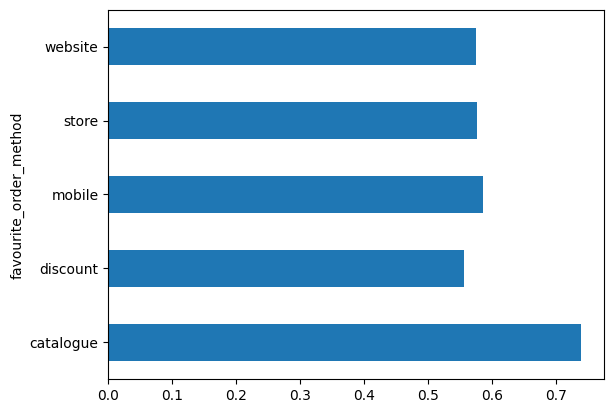

In [96]:
df.groupby('favourite_order_method').complain_count.mean().plot(kind='barh')

<Axes: ylabel='total_kids'>

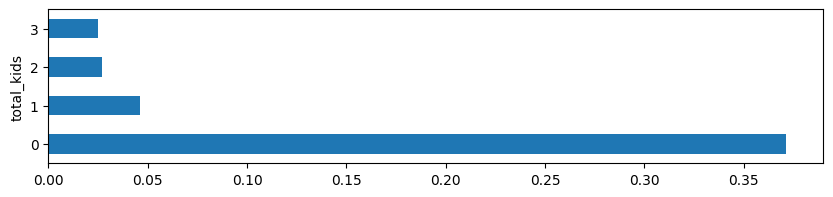

In [97]:
df.groupby('total_kids').avg_marketing_success.mean().plot(kind='barh', figsize=(10, 2))

<Axes: xlabel='avg_marketing_success'>

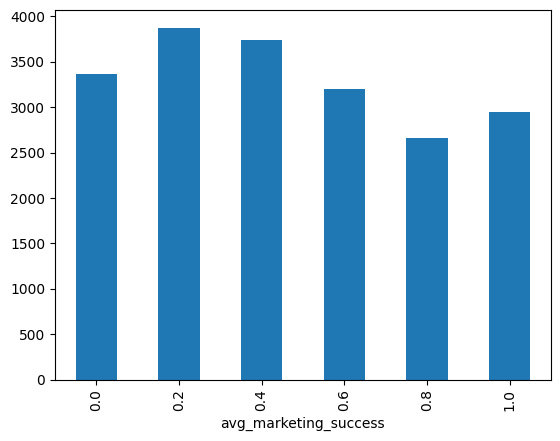

In [98]:
df.groupby('avg_marketing_success').avg_bill.mean().plot(kind='bar')

<Axes: ylabel='favourite_category'>

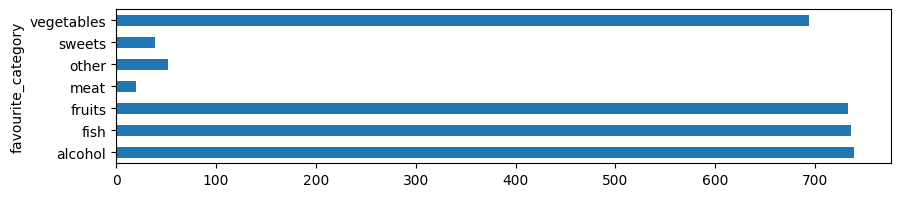

In [99]:
### Количество людей с определённой любимой категорией
df.favourite_category.value_counts().sort_index().plot(kind='barh', figsize=(10, 2))

<Axes: ylabel='favourite_category'>

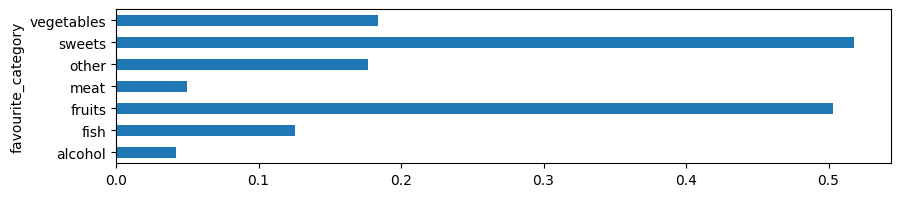

In [100]:
### Средний успех маркетинговых компаний для людей с определённой любимой категорией
df.groupby('favourite_category').avg_marketing_success.mean().plot(kind='barh', figsize=(10, 2))

<Axes: ylabel='favourite_category'>

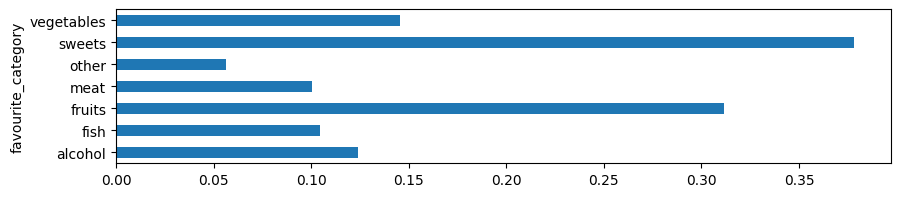

In [101]:
### Средняя доля покупок по скидке для людей с определённой любимой категорией
df.groupby('favourite_category').discount_frac.mean().plot(kind='barh', figsize=(10, 2))